In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
# tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.compat.v1.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.get_session()
K.set_session(sess)


In [2]:
# test harness for evaluating models on the cifar10 dataset
import sys
import numpy as np

from matplotlib import pyplot as plt
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD

from keras import backend as K




In [3]:
#check if GPU available 
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [4]:
def recall_(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_(y_true, y_pred):
    precision = precision_(y_true, y_pred)
    recall = recall_(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.plot()
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    # save plot to file
    plt.show()
    
    
    plt.plot()
    plt.title('Classification Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    # save plot to file
    plt.show()
    
    
    plt.plot()
    plt.title('Classification F1')
    plt.plot(history.history['f1_'], color='blue', label='train')
    plt.plot(history.history['val_f1_'], color='orange', label='test')
    plt.xlabel('epoch')
    plt.ylabel('F1')
    plt.legend()
    # save plot to file
    plt.show()
    
    
    plt.plot()
    plt.title('Classification Precision')
    plt.plot(history.history['precision_'], color='blue', label='train')
    plt.plot(history.history['val_precision_'], color='orange', label='test')
    plt.xlabel('epoch')
    plt.ylabel('precision')
    plt.legend()
    # save plot to file
    plt.show()
    
    plt.plot()
    plt.title('Classification Recall')
    plt.plot(history.history['recall_'], color='blue', label='train')
    plt.plot(history.history['val_recall_'], color='orange', label='test')
    plt.xlabel('epoch')
    plt.ylabel('recall')
    plt.legend()
    # save plot to file
    plt.show()
    

In [9]:
# load train and test dataset
def load_dataset10():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

def load_dataset100():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar100.load_data()
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

# run the test harness for evaluating a model
def run_test():
    # load dataset
    trainX, trainY, testX, testY = load_dataset10()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    model = define_model()
    # fit model
    history = model.fit(trainX, trainY, epochs=40, batch_size=64, validation_data=(testX, testY), verbose=1)
    # evaluate model
    loss, accuracy, f1_score, precision, recall = model.evaluate(testX, testY, verbose=0)
    print()
    print('accuracy > %.3f' % (accuracy * 100.0))
    print('loss > %.3f' % (loss * 100.0))
    print('f1 > %.3f' % (f1_score * 100.0))
    print('precision > %.3f' % (precision * 100.0))
    print('recall > %.3f' % (recall * 100.0))

    # learning curves
    summarize_diagnostics(history)
    model.save('./model/model_CIFAR10_dropout.h5')

    print("I am done")

In [10]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', f1_, precision_, recall_])
    return model

Epoch 1/40
782/782 [==============================] - 14s 18ms/step - loss: 2.0626 - accuracy: 0.2338 - f1_: 0.0281 - precision_: 0.3006 - recall_: 0.0151 - val_loss: 1.7641 - val_accuracy: 0.3522 - val_f1_: 0.0496 - val_precision_: 0.6229 - val_recall_: 0.0261
Epoch 2/40
782/782 [==============================] - 13s 17ms/step - loss: 1.7333 - accuracy: 0.3589 - f1_: 0.1591 - precision_: 0.5961 - recall_: 0.0940 - val_loss: 1.5931 - val_accuracy: 0.4296 - val_f1_: 0.1911 - val_precision_: 0.7269 - val_recall_: 0.1111
Epoch 3/40
782/782 [==============================] - 14s 18ms/step - loss: 1.5663 - accuracy: 0.4235 - f1_: 0.2692 - precision_: 0.6436 - recall_: 0.1725 - val_loss: 1.4918 - val_accuracy: 0.4648 - val_f1_: 0.2576 - val_precision_: 0.7516 - val_recall_: 0.1574
Epoch 4/40
782/782 [==============================] - 14s 17ms/step - loss: 1.4527 - accuracy: 0.4682 - f1_: 0.3477 - precision_: 0.6686 - recall_: 0.2372 - val_loss: 1.3427 - val_accuracy: 0.5097 - val_f1_: 0.3965

782/782 [==============================] - 13s 17ms/step - loss: 0.6075 - accuracy: 0.7865 - f1_: 0.7825 - precision_: 0.8524 - recall_: 0.7241 - val_loss: 0.6339 - val_accuracy: 0.7830 - val_f1_: 0.7784 - val_precision_: 0.8476 - val_recall_: 0.7206
Epoch 33/40
782/782 [==============================] - 13s 17ms/step - loss: 0.6024 - accuracy: 0.7896 - f1_: 0.7857 - precision_: 0.8540 - recall_: 0.7284 - val_loss: 0.6092 - val_accuracy: 0.7868 - val_f1_: 0.7859 - val_precision_: 0.8540 - val_recall_: 0.7288
Epoch 34/40
782/782 [==============================] - 13s 17ms/step - loss: 0.5950 - accuracy: 0.7913 - f1_: 0.7860 - precision_: 0.8549 - recall_: 0.7283 - val_loss: 0.6063 - val_accuracy: 0.7914 - val_f1_: 0.7888 - val_precision_: 0.8468 - val_recall_: 0.7391
Epoch 35/40
782/782 [==============================] - 13s 17ms/step - loss: 0.5828 - accuracy: 0.7944 - f1_: 0.7915 - precision_: 0.8571 - recall_: 0.7361 - val_loss: 0.6159 - val_accuracy: 0.7869 - val_f1_: 0.7819 - val_p

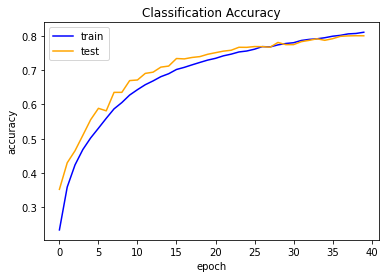

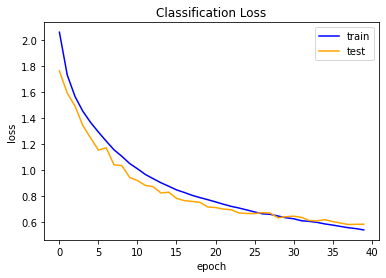

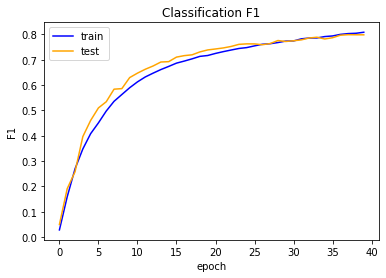

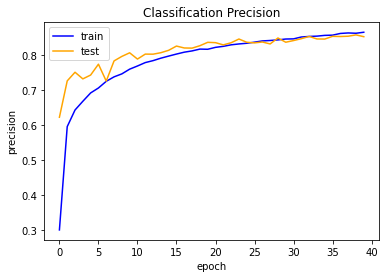

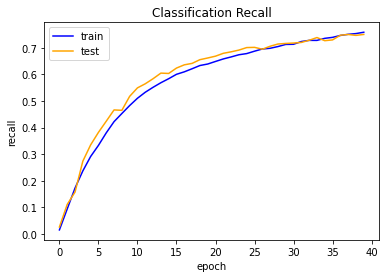

I am done


In [11]:

# entry point, run the test harness

run_test()

In [ ]:
print(define_model().summary())